Imports

In [1]:
# Library imports

# Library imports

from sklearn.datasets import fetch_openml
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

from torch.utils.data import DataLoader

import pandas as pd

MNIST Dataset Loader and Visualization

In [2]:
# MNIST Dataset Loader

# Fetch the MNIST dataset
mnist = fetch_openml('mnist_784', version=1, as_frame=False)

# Extract data and labels
x, y = mnist['data'], mnist['target']
y = y.astype(int)

Data shape: (70000, 784)
Labels shape: (70000,)


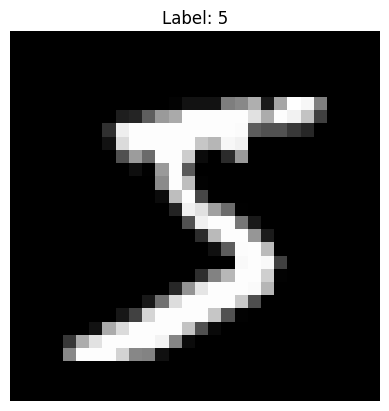

In [3]:
# MNIST Dataset Visualization

# Inspect the dataset
print(f"Data shape: {x.shape}")
print(f"Labels shape: {y.shape}")

# Visualize a sample
plt.imshow(x[0].reshape(28, 28), cmap='gray')
plt.title(f"Label: {y[0]}")
plt.axis('off')
plt.show()

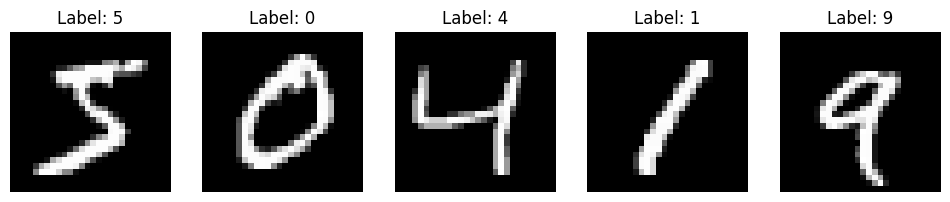

In [4]:
# Display a grid of 5 images
fig, axes = plt.subplots(1, 5, figsize=(12, 6))

for i in range(5):
    axes[i].imshow(x[i].reshape(28, 28), cmap='gray')
    axes[i].set_title(f"Label: {y[i]}")
    axes[i].axis('off')

plt.show()

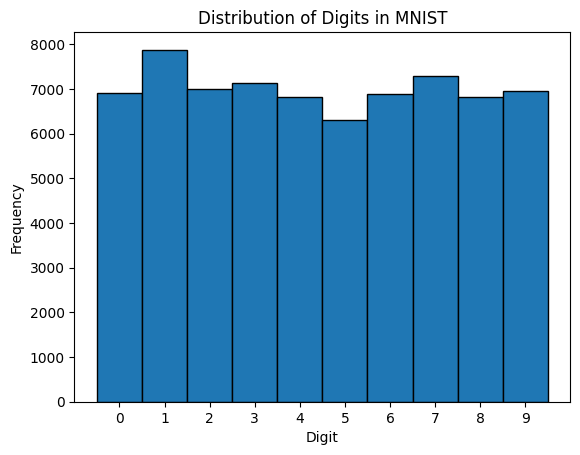

In [5]:
# Plot the distribution of labels
plt.hist(y, bins=np.arange(11) - 0.5, edgecolor='black')
plt.xticks(np.arange(10))
plt.title('Distribution of Digits in MNIST')
plt.xlabel('Digit')
plt.ylabel('Frequency')
plt.show()

Convolutional Neural Network (CNN)

In [6]:
# Define the Simple Convolutional Neural Network (CNN) architecture
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # Convolutional layer 1
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # Convolutional layer 2
        self.pool = nn.MaxPool2d(2, 2)  # Max-pooling layer
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # Fully connected layer 1
        self.fc2 = nn.Linear(128, 10)  # Fully connected output layer

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Apply conv1, ReLU activation, and pooling
        x = self.pool(F.relu(self.conv2(x)))  # Apply conv2, ReLU activation, and pooling
        x = x.view(-1, 64 * 7 * 7)  # Flatten the tensor
        x = F.relu(self.fc1(x))  # Fully connected layer 1 and ReLU activation
        x = self.fc2(x)  # Output layer
        return x

In [7]:
# Common for both "with augmentation" and "without augmentation"
# Transform for the test dataset (no augmentation)
transform_test = transforms.Compose([
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize the image
])

# Load the MNIST test dataset (common for both cases)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform_test)

In [8]:
# For training dataset without augmentation
transform_train = transforms.Compose([
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize the image
])

In [9]:
# Load the MNIST training dataset (with general augmentation or without augmentation)
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform_train)

In [10]:
# Instantiate the CNN model
model = SimpleCNN()  # Create an instance of the CNN class

# Loss function and optimizer for CNN (same as FCNN)
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for classification
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)  # Stochastic Gradient Descent

# Set up the DataLoader for training and testing
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)

# Training loop for the CNN model
epochs = 5
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0

     # Iterate over batches of data
    for inputs, labels in train_loader:
        inputs = inputs.view(-1, 1, 28, 28)  # Ensure the correct shape
        optimizer.zero_grad()  # Zero the gradients
        outputs = model(inputs)  # Pass the inputs through the CNN model
        loss = criterion(outputs, labels)  # Compute the loss
        loss.backward()  # Backpropagate the gradients
        optimizer.step()  # Update the model parameters
        running_loss += loss.item()  # Accumulate the loss for logging

    # Print the loss after each epoch
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}")

Epoch [1/5], Loss: 0.7815
Epoch [2/5], Loss: 0.1909
Epoch [3/5], Loss: 0.1224
Epoch [4/5], Loss: 0.0942
Epoch [5/5], Loss: 0.0789


In [11]:
# Add the overfitting check HERE after training
def evaluate_accuracy(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.view(-1, 1, 28, 28)  # Ensure correct shape
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    return correct / total

# Move model to the correct device (GPU/CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Compute train and test accuracy
train_accuracy = evaluate_accuracy(model, train_loader, device)
test_accuracy = evaluate_accuracy(model, test_loader, device)

# Print results
print(f"\n Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Check for overfitting
if train_accuracy - test_accuracy > 0.05:  # Threshold for overfitting
    print("\n Possible Overfitting: Large gap between Train and Test accuracy.")
else:
    print("\n No significant overfitting detected.")


 Train Accuracy: 0.9784
Test Accuracy: 0.9807

 No significant overfitting detected.


In [12]:
# Save the model
torch.save(model.state_dict(), "cnn_baseline.pth")  # Save the model parameters
# print("Model saved as cnn_model.pth")

In [13]:
# Function to evaluate the model and save metrics
def evaluate_and_store_model(model_version, model, dataloader, device, results):
    """
    Evaluate the model and store metrics for the given version.

    Args:
        model_version (str): Name of the model version.
        model (torch.nn.Module): Trained PyTorch model.
        dataloader (torch.utils.data.DataLoader): Test dataloader.
        device (torch.device): Device (CPU/GPU) used for evaluation.
        results (dict): Dictionary to store metrics for all models.
    """
    model.eval()  # Set the model to evaluation mode
    y_true = []  # List to store true labels
    y_pred = []  # List to store predicted labels

    # Disable gradient computation during evaluation
    with torch.no_grad():
        for inputs, labels in dataloader:
            # Move data to the evaluation device (CPU or GPU)
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass: Get predictions from the model
            outputs = model(inputs)

            # Get the predicted class (index with the highest score)
            _, predicted = torch.max(outputs, 1)

            # Append true and predicted labels to their respective lists
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Compute evaluation metrics
    metrics = {
        "accuracy": accuracy_score(y_true, y_pred),  # Overall accuracy
        "precision": precision_score(y_true, y_pred, average='macro', zero_division=1),  # Precision for all classes
        "recall": recall_score(y_true, y_pred, average='macro', zero_division=1),  # Recall for all classes
        "f1_score": f1_score(y_true, y_pred, average='macro', zero_division=1),  # F1 score for all classes
        "confusion_matrix": confusion_matrix(y_true, y_pred).tolist()  # Confusion matrix as a list
    }

    # Save metrics for the current model version in the results dictionary
    results[model_version] = metrics


# Set up the device (use GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize an empty dictionary to store metrics for all models
results = {}

# List of saved models with their version names
saved_models = {
    "cnn_baseline.pth": "Baseline CNN"  # First model
    # "cnn_epochs20.pth": "CNN with 20 Epochs",  # Second model
    # "cnn_augmentation.pth": "CNN with augmentation",  # Third model
    # "cnn_augmentation_class.pth": "CNN with Class-Specific augmentation",  # Four model
    # "cnn_baseline2.pth": "Baseline2"  # Fith model

}

# Test DataLoader (assuming it is already set up)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=128, shuffle=False)

# Loop through all saved models and evaluate them
for model_path, model_version in saved_models.items():
    # Load the model (replace `YourModelClass` with your actual model class name)
    model = SimpleCNN()

    # Load the trained weights into the model
    model.load_state_dict(torch.load(model_path, map_location=device))

    # Move the model to the evaluation device (CPU or GPU)
    model.to(device)

    # Evaluate the model and store its metrics
    evaluate_and_store_model(model_version, model, test_loader, device, results)


C:\Users\user\AppData\Local\Temp\ipykernel_24112\1167374403.py:71: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=de

In [14]:
# Save the confusion matrix for each model
for model, metrics in results.items():
    confusion_matrix = metrics["confusion_matrix"]
    matrix_df = pd.DataFrame(confusion_matrix,
                             index=[f"Actual_{i}" for i in range(len(confusion_matrix))],
                             columns=[f"Predicted_{i}" for i in range(len(confusion_matrix[0]))])
    matrix_df.to_csv(f"{model.replace(' ', '_')}_confusion_matrix.csv", sep=";")

# Save high-level metrics in a summary file
summary_table = {
    model: {
        "Accuracy": metrics["accuracy"],
        "Precision": metrics["precision"],
        "Recall": metrics["recall"],
        "F1 Score": metrics["f1_score"]
    }
    for model, metrics in results.items()
}

df = pd.DataFrame.from_dict(summary_table, orient="index")
df.to_csv("model_metrics_summary.csv", sep=";", index=True)

# Print the table in the console
print(df)

              Accuracy  Precision    Recall  F1 Score
Baseline CNN    0.9807   0.980994  0.980581  0.980679
